This notebook contains a simulation and code for testing and developing a VAE for fitting models across multiple subjects

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib qt 
%matplotlib inline

In [3]:
import itertools

from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Define helper functions here

In [4]:
def gen_couplings(neuron_ctrs, mode_ctr, mode_pos_std, mode_ctr_mean, mode_noise_std):
    """ Generates ground truth couplings. """
    weighted_distance_from_ctrs = np.sum(((neuron_ctrs - mode_ctr)/mode_pos_std)**2, axis=1)
    coupling_means = mode_ctr_mean*np.exp(-1*weighted_distance_from_ctrs)
    return np.random.randn(len(coupling_means))*mode_noise_std + coupling_means 

In [5]:
def visualize_couplings(neuron_ctrs, p_couplings, u_couplings, max_mag=1):
    """ Generates plots of couplings. """
    n_neurons = neuron_ctrs.shape[0]
    n_modes = p_couplings.shape[1]
    
    cmap = matplotlib.cm.get_cmap('PiYG')
    
    for m_i in range(n_modes):
        a = plt.subplot(n_modes, 2, 2*m_i + 1)
        for n_i in range(n_neurons):
            c_vl = p_couplings[n_i, m_i]/(2*max_mag) + .5
            clr = cmap(c_vl)
            p = plt.plot(neuron_ctrs[n_i,0], neuron_ctrs[n_i,1], 'ko', 
                        alpha=.5, markerfacecolor=clr)
        a.set_xticklabels([])
        a.set_yticklabels([])
        if m_i == 0:
            plt.title('P Couplings')
        
        a = plt.subplot(n_modes, 2, 2*m_i + 2)
        for n_i in range(n_neurons):
            c_vl = u_couplings[n_i, m_i]/(2*max_mag) + .5
            clr = cmap(c_vl)
            p = plt.plot(neuron_ctrs[n_i,0], neuron_ctrs[n_i,1], 'ko', 
                         alpha=.5, markerfacecolor=clr)
        a.set_xticklabels([])
        a.set_yticklabels([])
        if m_i == 0:
            plt.title('U Couplings')

In [6]:
def get_prop_dist_images(d, x_range = [0, 1], y_range = [0, 1]):
    
    n_points_per_side = 100
    
    # Get grid of points 
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side*1j, y_range[0]:y_range[1]:n_points_per_side*1j]
    
    grid_vec = np.stack([np.ravel(grid[0,:,:]), np.ravel(grid[1,:,:])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))
    
    mn = d.mean(grid_vec).detach().numpy() 
    
    n_modes = mn.shape[1]
    mn_image = np.zeros([n_modes, n_points_per_side, n_points_per_side])
    for m_i in range(n_modes):
        mn_image[m_i, :, :] = np.reshape(mn[:,m_i], [n_points_per_side, n_points_per_side])
    
    return mn_image

## Parameters go here

In [7]:
n_neurons_per_subject = [90, 100, 110, 80, 102] # Length implicitly defines # of subjects

n_smps_per_subject = [1000, 1100, 900, 999, 1230] # Number of (x,y) pairs for each subject

# We model distributions of couplings with bumps - where the magnitude of a coupling is a 
# function of how far that neuron is from the center of the bump + some noise 

# Here we specify the centers where couplings are heighest for each p mode
p_mode_centers = np.asarray([[.5, .5]])
#p_mode_centers = np.asarray([[.2, .2], [.5, .5], [.8, .8]]) 


# Here we specify the standard deviation of the spatial extents of couplings for each p mode
p_mode_pos_stds = np.asarray([[.5, .5]])
#p_mode_pos_stds = np.asarray([[.5, .5], [.5, .5], [.5, .5]]) 

# Here we define the mean value for a coupling at the center of each mode
p_mode_mean_center_coupling = [1]
#p_mode_mean_center_coupling = [1, 1, 1]

# Here we define how much noise to add when generating couplings for each mode
p_mode_noise_stds = [.05]
#p_mode_noise_stds = [.05, .05, .05]

# Parmeters for generate u mode couplings 
u_mode_centers = np.asarray([[.5, .2]])
#u_mode_centers = np.asarray([[.2, .2], [.5, .5], [.8, .8]]) # Physical centers of u modes

u_mode_pos_stds = np.asarray([[1, .2]])
#u_mode_pos_stds = np.asarray([[.5, .5], [.5, .5], [.5, .5]])

u_mode_mean_center_coupling = [1]
#u_mode_mean_center_coupling = [1, -1, 1]

u_mode_noise_stds = [.05]
#u_mode_noise_stds = [.05, .05, .05]

# Range to generate neuron private noise variances from, for each subject
priv_noise_var_ranges = np.asarray([[.5, .8],
                                    [.5, .8],
                                    [.5, .8],
                                    [.5, .8],
                                    [.5, .8]])

## Generate each ground truth model and data

In [8]:
n_subjects = len(n_neurons_per_subject)
n_modes = p_mode_centers.shape[0]
subjects = [None]*n_subjects
for s_i in range(n_subjects):
    n_neurons = n_neurons_per_subject[s_i]
    n_smps = n_smps_per_subject[s_i]
    
    # Generate neuron locations uniformly in the unit square
    neuron_x = np.random.rand(n_neurons)
    neuron_y = np.random.rand(n_neurons)
    neuron_ctrs = np.stack([neuron_x, neuron_y]).transpose()
    
    # Generate couplings 
    p = np.zeros([n_neurons, n_modes])
    u = np.zeros([n_neurons, n_modes])
    for m_i in range(n_modes):
        p[:, m_i] = gen_couplings(neuron_ctrs, p_mode_centers[m_i,:], p_mode_pos_stds[m_i,:], 
                          p_mode_mean_center_coupling[m_i], p_mode_noise_stds[m_i])
        u[:, m_i] = gen_couplings(neuron_ctrs, u_mode_centers[m_i,:], u_mode_pos_stds[m_i,:], 
                          u_mode_mean_center_coupling[m_i], u_mode_noise_stds[m_i])
        
    # Generate x smps - these just come from a standard normal 
    x = np.random.randn(n_smps, n_neurons)
    
    # Generate means for each y smp
    l = np.matmul(x, p)
    y_mn = np.matmul(l, u.transpose())
    
    # Generate private noise variances
    priv_var_width = priv_noise_var_ranges[s_i,1] - priv_noise_var_ranges[s_i,0]
    priv_var = np.random.rand(n_neurons)*priv_var_width + priv_noise_var_ranges[s_i,0]
    
    # Generate y smps
    y_noise = np.random.randn(n_smps, n_neurons)*priv_var
    y = y_mn + y_noise
    
    # Store results
    s_dict = dict()
    s_dict['n_neurons'] = n_neurons
    s_dict['n_smps'] = n_smps
    s_dict['neuron_ctrs'] = neuron_ctrs
    s_dict['p'] = p
    s_dict['u'] = u
    s_dict['priv_var'] = priv_var
    s_dict['x'] = x
    s_dict['y'] = y
    s_dict['y_mn'] = y_mn
    s_dict['p_mode_centers'] = p_mode_centers
    s_dict['u_mode_centers'] = u_mode_centers
    s_dict['p_mode_pos_stds'] = p_mode_pos_stds
    s_dict['u_mode_pos_stds'] = u_mode_pos_stds
    s_dict['p_mode_noise_stds'] = np.asarray(p_mode_noise_stds)
    s_dict['u_mode_noise_stds'] = np.asarray(u_mode_noise_stds)
    s_dict['p_mode_mean_center_coupling'] = np.asarray(p_mode_mean_center_coupling)
    s_dict['u_mode_mean_center_coupling'] = np.asarray(u_mode_mean_center_coupling)
    
    subjects[s_i] = s_dict

## Look at ground truth data for one subject

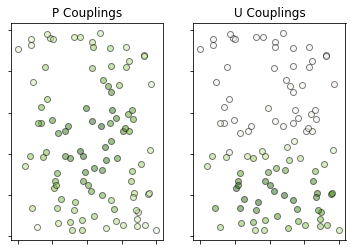

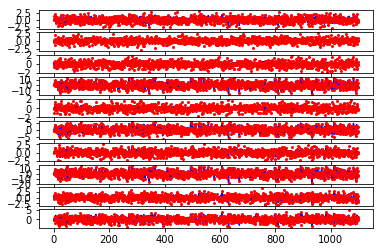

In [9]:
vis_subj = 1 # The subject we want to visualize ground truth for
subject = subjects[vis_subj]


# Visualize couplings
plt.figure()
visualize_couplings(subject['neuron_ctrs'], 
                    subject['p'], 
                    subject['u'])

# Visualize y data
roi_inds = np.arange(0, subject['n_neurons'], 10)
plt.figure()
for i, roi_i in enumerate(roi_inds):
    plt.subplot(len(roi_inds), 1, i+1)
    plt.plot(subject['y_mn'][:, roi_i], 'b-')
    plt.plot(subject['y'][:, roi_i], 'ro', markersize=2)

## Define Objects We Need for Variational Inference

In [ ]:
class GaussianRankOneWDistribution(torch.nn.Module)

In [ ]:
class ConditionalCouplingsDistrbution(torch.nn.Module):
    """ Distribution of couplings for either p or u given measurable properties for one neuron.
    """
    
    def __init__(self, n_modes: int, n_properties: int):
        
        super().__init__()
        
        self.n_modes = n_modes
        self.n_properties = n_properties
        
        self.centersP = torch.nn.Parameter(torch.zeros([n_modes, n_properties]), requires_grad=True)
        torch.nn.init.uniform_(self.centersP, 0, 1)
        
        self.log_prop_stds = torch.nn.Parameter(torch.zeros([n_modes,n_properties]), requires_grad=True)
        torch.nn.init.normal_(self.log_prop_stds, mean=1, std=.1)
        
        if use_gain:
            self.gains = torch.nn.Parameter(torch.zeros(n_modes), requires_grad=True)
            torch.nn.init.normal_(self.gains)
        
        self.log_noise_stds = torch.nn.Parameter(torch.zeros(n_modes), requires_grad=True)
        torch.nn.init.normal_(self.log_noise_stds)
    
    def forward(self, properties: torch.Tensor):
        """ Computes means given properties for a set of neurons. 
        
        Args:
            properties: Of shape n_neurons*n_properties
        """
        
        prop_stds = torch.exp(self.log_prop_stds)
        
        properties_view =  properties.unsqueeze(1).repeat([1, self.n_modes, 1])
        properties_weighted_delta = properties_view - self.centers
        properties_distance = torch.sum((properties_weighted_delta/prop_stds)**2, dim=2)
        
        if self.use_gain:
            gains = self.gains
        else:
            gains = 1
            
        mns = torch.exp(-1*properties_distance)*gains
        
        return mns
    
    def mean(self, properties: torch.Tensor):
        return self(properties)
    
    def log_std(self, properties: torch.Tensor):
        """ Conditional log_std given properites for multiple neurons. 
        
            Currently log_std is invariant to properties. 
        """
        
        n_neurons = properties.shape[0]
        
        noise_log_std =  self.log_noise_stds
        return noise_log_std.unsqueeze(0).repeat(n_neurons, 1)
    
    def std(self, properties: torch.Tensor):
        """ Conditional std given properites for multiple neurons. 
        
            Currently std is invariant to properties. 
        """
        
        n_neurons = properties.shape[0]
        
        noise_std =  torch.exp(self.log_noise_stds)
        return noise_std.unsqueeze(0).repeat(n_neurons, 1)
    
    def sample(self, properties: torch.Tensor):
        mn = self.mean(properties)
        std = self.std(properties)
        return mn + std*torch.randn(std.shape)

In [ ]:
class TanhConditionalCouplingsDistrbution(torch.nn.Module):
    """ Distribution of couplings for either p or u given measurable properties for one neuron.
    """
    
    def __init__(self, n_modes: int, n_properties: int):
        
        exp_factor = 10
        
        super().__init__()
        
        self.n_modes = n_modes
        self.n_properties = n_properties
        
        l1_list = [torch.nn.Linear(n_properties, n_properties*exp_factor) for m_i in range(n_modes)]
        
        l2_list = [torch.nn.Linear(n_properties*exp_factor, n_properties*exp_factor) 
                   for m_i in range(n_modes)]
        
        l3_list = [torch.nn.Linear(n_properties*exp_factor, 1) 
                   for m_i in range(n_modes)]
        
        self.l1 = torch.nn.ModuleList(l1_list)
        self.l2 = torch.nn.ModuleList(l2_list)
        self.l3 = torch.nn.ModuleList(l3_list)
        
        self.log_noise_stds = torch.nn.Parameter(torch.zeros(n_modes), requires_grad=True)
        torch.nn.init.normal_(self.log_noise_stds)
        
    def _one_mode_forward(self, properties: torch.Tensor, mode_i):
        y = self.l1[mode_i](properties)
        y = torch.tanh(y)
        y = self.l2[mode_i](y)
        y = torch.tanh(y)
        y = self.l3[mode_i](y)
        return torch.squeeze(y)
        
    def forward(self, properties: torch.Tensor):
        """ Computes means given properties for a set of neurons. 
        
        Args:
            properties: Of shape n_neurons*n_properties
        """
        mode_mns = [self._one_mode_forward(properties, m_i) for m_i in range(self.n_modes)]
        return torch.stack(mode_mns).t()

    def mean(self, properties: torch.Tensor):
        return self(properties)
    
    def log_std(self, properties: torch.Tensor):
        """ Conditional log_std given properites for multiple neurons. 
        
            Currently log_std is invariant to properties. 
        """
        
        n_neurons = properties.shape[0]
        
        noise_log_std =  self.log_noise_stds
        return noise_log_std.unsqueeze(0).repeat(n_neurons, 1)
    
    def std(self, properties: torch.Tensor):
        """ Conditional std given properites for multiple neurons. 
        
            Currently std is invariant to properties. 
        """
        
        n_neurons = properties.shape[0]
        
        noise_std =  torch.exp(self.log_noise_stds)
        return noise_std.unsqueeze(0).repeat(n_neurons, 1)
        
    def sample(self, properties: torch.Tensor):
        mn = self.mean(properties)
        std = self.std(properties)
        return mn + std*torch.randn(std.shape)

In [ ]:
class ConditionalYDistribution(torch.nn.Module):
    """ Conditional distribution for y|x, p, u for a particular subject. 
    """
    
    def __init__(self, n_neurons: int):
        
        super().__init__()
         
        self.log_std = torch.nn.Parameter(torch.zeros(n_neurons), requires_grad=True)
        torch.nn.init.normal_(self.log_std)
        
    def forward(self, x: torch.Tensor, p: torch.Tensor, u: torch.Tensor):
        """ Computes conditional mean.
        
        Args:
            x: input of shape n_smps * n_neurons
            
            p: modes which project to latents of shape n_neurons * n_modes
            
            u: modes which project back to mean firing rates, of shape n_neurons * n_modes
        """
        l = torch.matmul(x, p)
        mns = torch.matmul(l, u.t())
        
        return mns
        
    def cond_neg_ll(self, mn: torch.Tensor, y: torch.Tensor):
        n_smps = mn.shape[0]
        log_2_pi = float(np.log(2*np.pi))
        
        psi = torch.exp(self.log_std)
        
        neg_ll = .5*mn.nelement()*log_2_pi
        neg_ll += n_smps*torch.sum(self.log_std) # don't need .5 here b/c we are taking log of std^2
        neg_ll += .5*torch.sum(((y - mn)/psi)**2)
        
        return neg_ll

## Define function we will use for calculating KL divergence 

In [ ]:
def kl(d0: torch.nn.Module, d1: torch.nn.Module, x: torch.Tensor):
    """ Computes the KL divergence between two conidtional distributions given input.
        
    Given distribution d0 and d1, this will compute KL(d0, d1).     
    
    Args:
        d0: Module representing a conditional multivariate normal distribution.  Must have 
        the methods:
            'mean' - returns the mean of a distribution given some input
                
            'std' - returns the square root of the diagonal of the covariance matrix given
                    some input. 
                        
            'log_std' - returns the log of the square root of the diagonal of the covariance
                        matrix given some input
                
            Note that the returned arguments can be shaped as general tensors (i.e., 
            they don't have to be vectorized.)
            
        d1: Same as d0, but for the second distribution
            
        x: input we condition on, of shape n_smps * n_neurons
    """
    
    psi_0 = d0.std(x)**2
    psi_1 = d1.std(x)**2
           
    k = psi_0.nelement()
        
    mn_0 = d0.mean(x)
    mn_1 = d1.mean(x)
    mn_diff = mn_1 - mn_0
        
    kl = -.5*k
    kl += .5*torch.sum(psi_0/psi_1)
    kl += .5*torch.sum((mn_diff**2)/psi_1)
    kl += torch.sum(d1.log_std(x))
    kl -= torch.sum(d0.log_std(x))
        
    return kl
        
        

## Define object we will use to fit with variational inference

In [ ]:
class MultiSubjectVIFitter(torch.nn.Module):
    
    def __init__(self, subject_models, p_cond_prior, u_cond_prior, subject_p_q_dists, subject_u_q_dists, kl):
        
        super().__init__()
        
        self.subject_models = torch.nn.ModuleList(subject_models)
        self.p_cond_prior = p_cond_prior
        self.u_cond_prior = u_cond_prior
        self.subject_p_q_dists = torch.nn.ModuleList(subject_p_q_dists)
        self.subject_u_q_dists = torch.nn.ModuleList(subject_u_q_dists)
        self.kl = kl
        
    def forward(self, x: list, props: list):
        """
        Samples couplings for each model and computes conditional means.
        
        """
        
        n_subjects = len(x)
        
        # Forward pass for each subject
        mns = [None]*n_subjects
        for s_i in range(n_subjects):
            
            # Sample couplings for this subject
            p_smp = self.subject_p_q_dists[s_i].sample(props[s_i])
            u_smp = self.subject_u_q_dists[s_i].sample(props[s_i])
            
            mns[s_i] = self.subject_models[s_i](x[s_i], p_smp, u_smp)
        
        return mns
    
    def cost(self, x: list, y:list, props:list):
        """ Compute the objective value for fitting the VI objective over all models. """
        
        n_subjects = len(x)
       
        nll_cost = 0
        # Compute likelihood term (couplings are sampled in this step)
        mns = self(x, props)
        for s_i in range(n_subjects):
            nll_cost += self.subject_models[s_i].cond_neg_ll(mns[s_i], y[s_i])
            
        # Compute KL divergence term for distribution on p modes 
        p_cost = 0
        for s_i in range(n_subjects):
            p_cost += self.kl(self.subject_p_q_dists[s_i], self.p_cond_prior, props[s_i])
        
        # Compute KL divergence term for distribution on u modes
        u_cost = 0
        for s_i in range(n_subjects):
            u_cost += self.kl(self.subject_u_q_dists[s_i], self.u_cond_prior, props[s_i])
             
        return [nll_cost, p_cost, u_cost]
    
    def pre_train_cost(self, x: list, y: list, props: list):
        " Cost for training subject models and priors with Monte Carlo sampling. "
        
        n_subjects = len(x)
          
        cost = 0
        for s_i in range(n_subjects):
            p_smp = self.p_cond_prior.sample(props[s_i])
            u_smp = self.u_cond_prior.sample(props[s_i])
            
            mn = self.subject_models[s_i](x[s_i], p_smp, u_smp)

            cost += self.subject_models[s_i].cond_neg_ll(mn, y[s_i])
        
        return cost
    
    def fit(self, x: list, y: list, props: list, 
            lr: float = .001, max_n_its: int = 10, update_int: int = 1000, 
            batch_size = 100):
        
        n_subjects = len(x)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        batch_x = [None]*n_subjects
        batch_y = [None]*n_subjects
        
        for s_i in range(n_subjects):
            n_smps = x[s_i].shape[0]
            smps = np.random.choice(n_smps, batch_size, replace=False)
        
            batch_x[s_i] = x[s_i][smps, :]
            batch_y[s_i] = y[s_i][smps, :]
        
        for i in range(max_n_its):

            optimizer.zero_grad()
            nll_cost, p_cost, u_cost = self.cost(batch_x, batch_y, props)
            total_cost = nll_cost  + p_cost + u_cost
            total_cost.backward()
            optimizer.step()
            
            if i % update_int == 0:
                
                clear_output(wait = True)
                
                print('Completed iteration ' + str(i) + ', total_cost: ' + str(total_cost))
                print('nll_cost: ' + str(nll_cost))
                print('p_cost: ' + str(p_cost))
                print('u_cost: ' + str(u_cost))
                
                plot_updated_priors()
                
                
    def pre_train(self, x: list, y: list, props: list, 
                  lr: float = .001, max_n_its: int = 10, update_int: int = 1000):
        
        parameters = itertools.chain(self.subject_models.parameters(), 
                                     self.p_cond_prior.parameters(), 
                                     self.u_cond_prior.parameters())
        
        optimizer = torch.optim.Adam(parameters, lr=lr)
        for i in range(max_n_its):
            optimizer.zero_grad()
            cost = self.pre_train_cost(x, y, props)
            cost.backward()
            optimizer.step()
            
            if i % update_int == 0:
                print('Completed iteration ' + str(i) + ', cost: ' + str(cost))
        

## Get true prior distributions

In [ ]:
n_properties = u_mode_centers.shape[1]

true_p_cond_prior = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
true_p_cond_prior.centers.data = torch.from_numpy(subjects[0]['p_mode_centers'].astype('float32'))
true_p_cond_prior.gains.data = torch.from_numpy(subjects[0]['p_mode_mean_center_coupling'].astype('float32'))
true_p_cond_prior.log_prop_stds.data = torch.from_numpy(np.log(subjects[0]['p_mode_pos_stds']).astype('float32'))

true_u_cond_prior = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
true_u_cond_prior.centers.data = torch.from_numpy(subjects[0]['u_mode_centers'].astype('float32'))
true_u_cond_prior.gains.data = torch.from_numpy(subjects[0]['u_mode_mean_center_coupling'].astype('float32'))
true_u_cond_prior.log_prop_stds.data = torch.from_numpy(np.log(subjects[0]['u_mode_pos_stds']).astype('float32'))

## Set function for visualizing fits during the fitting proess

In [ ]:
def plot_updated_priors():
    
    true_p_image = get_prop_dist_images(true_p_cond_prior)
    est_p_image = get_prop_dist_images(p_cond_prior)
    p_q_image = get_prop_dist_images(p_q_dist)

    true_u_image = get_prop_dist_images(true_u_cond_prior)
    est_u_image = get_prop_dist_images(u_cond_prior)
    u_q_image = get_prop_dist_images(u_q_dist)
    
    for m_i in range(n_modes):
        
        plt.figure()
        
        cmp_n_mats([true_p_image[m_i, :,:], est_p_image[m_i, :,:], p_q_image[m_i, :, :],
                    true_u_image[m_i, :, :], est_u_image[m_i, :, :], u_q_image[m_i, :, :]], 
               titles=['E(p_' + str(m_i) + '), true', 'E(p_' + str(m_i) + '), fit', 'E(p_' + str(m_i) + '), q',
                       'E(u_' + str(m_i) + '), true', 'E(u_' + str(m_i) + '), fit', 'E(u_' + str(m_i) + '), q',],   
               cmap='PiYG', show_colorbars=False, clim = [-1, 1])
    
    plt.pause(0.05)
    plt.show()

## Set up all objects we need for fitting

In [ ]:
n_modes = subjects[0]['u'].shape[1]
n_properties = subjects[0]['neuron_ctrs'].shape[1]

In [ ]:
subject_models = [ConditionalYDistribution(subject['n_neurons']) for subject in subjects]
#p_cond_prior = TanhConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
#u_cond_prior = TanhConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)

p_cond_prior = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties, use_gain=True)
u_cond_prior = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties, use_gain=True)

#subject_p_q_dists = [MultiNeuronCouplingVariationalDistribution(subject['p'].shape) for subject in subjects]
#subject_u_q_dists = [MultiNeuronCouplingVariationalDistribution(subject['u'].shape) for subject in subjects]

#p_q_dist = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
#u_q_dist = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
p_q_dist = TanhConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)
u_q_dist = TanhConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)

subject_p_q_dists = [p_q_dist for subject in subjects]
subject_u_q_dists = [u_q_dist  for subject in subjects]

fitter = MultiSubjectVIFitter(subject_models, p_cond_prior, u_cond_prior, subject_p_q_dists, subject_u_q_dists, kl)

## Set things up for training

In [ ]:
x = [torch.from_numpy(subject['x'].astype('float32')) for subject in subjects]
y = [torch.from_numpy(subject['y'].astype('float32')) for subject in subjects]
props = [torch.from_numpy(subject['neuron_ctrs'].astype('float32')) for subject in subjects]

## Perform Pre-training

In [ ]:
#fitter.pre_train(x, y, props, max_n_its=10000, lr=.01, update_int=100)

## Perform Fitting

In [ ]:
fitter.fit(x,y, props, max_n_its=10000, lr=.01, update_int=100, batch_size=900)

## View results of fit for an example subject

In [ ]:
preds = fitter(x, props)

In [ ]:
vis_subj = 2

In [ ]:
subject = subjects[vis_subj] 

# Visualize y data
roi_inds = np.arange(0, subject['n_neurons'],10)
roi_inds = np.arange(0, 10)

y_true = subject['y_mn']
y_pred = preds[vis_subj].detach().numpy()

plt.figure()
for i, roi_i in enumerate(roi_inds):
    plt.subplot(len(roi_inds), 1, i+1)
    plt.plot(y_true[:, roi_i], 'b-')
    plt.plot(y_pred[:, roi_i], 'ro', markersize=2)

In [ ]:
# Visualize couplings 
plt.figure()
true_p = subject['p']
mn_p = subject_p_q_dists[vis_subj].mean(props[vis_subj]).detach().numpy()
cmp_n_mats([true_p, -1*mn_p], titles=['Truth', 'Q_p Mean'], show_colorbars=True)

plt.figure()
true_u = subject['u']
mn_u = subject_u_q_dists[vis_subj].mean(props[vis_subj]).detach().numpy()
cmp_n_mats([true_u, -1*mn_u], titles=['Truth', 'Q_u Mean'], show_colorbars=True)

plt.figure()
true_w = np.matmul(true_u, true_p.transpose())
mn_w = np.matmul(mn_u, mn_p.transpose())
cmp_n_mats([true_w, mn_w], titles=['Truth', 'Mean Couplings'], show_colorbars=True)

## View results of fitting conditional priors on properties 

In [ ]:
plt.figure()
visualize_couplings(subjects[vis_subj]['neuron_ctrs'], 
                    subject_p_q_dists[vis_subj].mean(props[vis_subj]).detach().numpy(), 
                    subject_u_q_dists[vis_subj].mean(props[vis_subj]).detach().numpy())

## Scratch below this

In [ ]:
kl(subject_p_q_dists[vis_subj], p_cond_prior, props[vis_subj])

In [ ]:
vis_subj = 4

In [ ]:
new_p_cond_prior = ConditionalCouplingsDistrbution(n_modes=n_modes, n_properties=n_properties)

In [ ]:
parameters = new_p_cond_prior.parameters()

optimizer = torch.optim.Adam(parameters)

for i in range(10000):
        optimizer.zero_grad()
        
        cost = 0
        for s_i in range(n_subjects):
            cost += kl(subject_p_q_dists[s_i], new_p_cond_prior, props[s_i])
        if i % 1000 == 0:
            print(str(i) + ': ' + str(cost))
            
        cost.backward()
        optimizer.step()
    

In [ ]:
new_p_image = get_prop_dist_images(new_p_cond_prior)

In [ ]:
plt.imshow(new_p_image[0,:,:])
plt.colorbar()

In [ ]:
torch.randn([3,2])

In [ ]:
u_cond_prior.gains

In [ ]:
p_q_dist.gains

In [ ]:
p_q_dist.centers

In [ ]:
p_cond_prior.gains

In [ ]:
l1 = torch.nn.Linear(10, 2)

In [ ]:
x = torch.randn([50, 10])

In [ ]:
l1(x).shape

In [ ]:
plt.imshow(est_u_image[0,:,:])
plt.colorbar()